In [200]:
#Libraries required for my code to run

#Uncomment this if you want to display your [graphs] within the notebook in a proper format.
%matplotlib inline
#Uncomment this if you want to display your graphs in backend


import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 
from pandas import DataFrame
import pandas as pd
import numpy as np
from numpy.random import randn
import glob
import sys

import warnings
warnings.filterwarnings('ignore')

from PIL import Image 
from sklearn import mixture
from sklearn.cluster import KMeans
%matplotlib inline

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, multivariate_normal


#Libraries required for my code to run

#Uncomment this if you want to display your [graphs] within the notebook in a proper format.
%matplotlib inline
#Uncomment this if you want to display your graphs in backend


import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 
from pandas import DataFrame
import pandas as pd
import numpy as np
from numpy.random import randn
import glob
import sys

import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


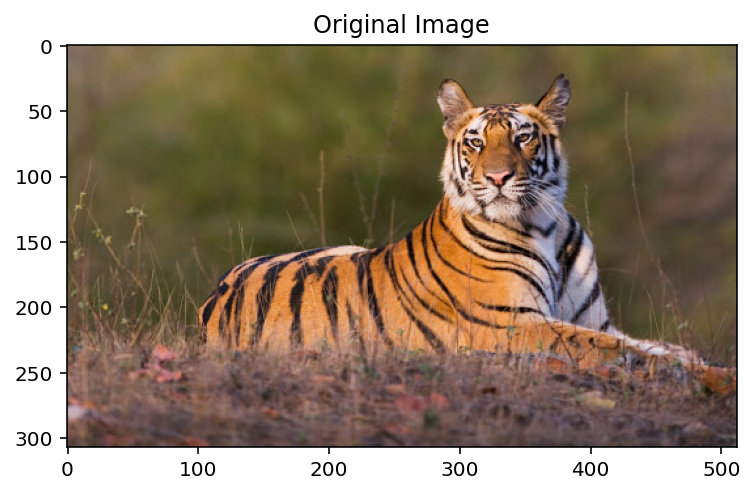

[1 1 1 ... 3 3 3]


In [201]:
img = np.array(Image.open('tiger.jpg'))
plt.imshow(img)
plt.title('Original Image')
plt.show()
img_reshapedto2D=img.reshape((-1,3));
model = mixture.GaussianMixture(n_components=4, covariance_type='full',random_state=8).fit(img_reshapedto2D)
original_labels = model.predict(img_reshapedto2D);
print(original_labels)

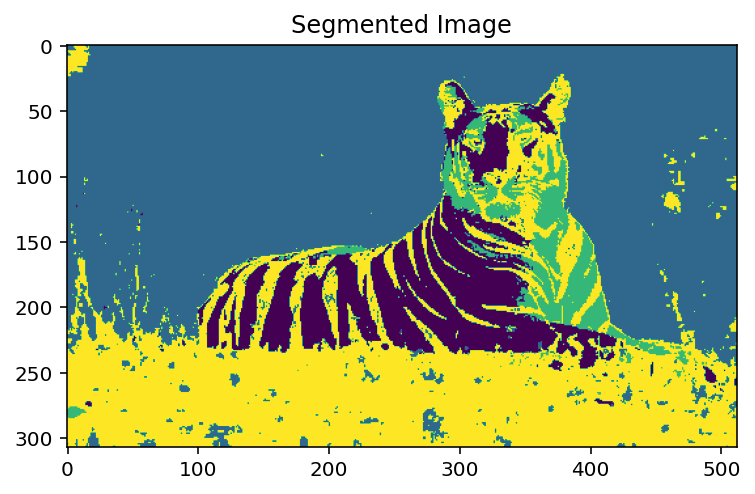

In [202]:
final_segmented_image = original_labels.reshape(img.shape[0],img.shape[1]);
plt.imshow(final_segmented_image)
plt.title('Segmented Image')
plt.show()

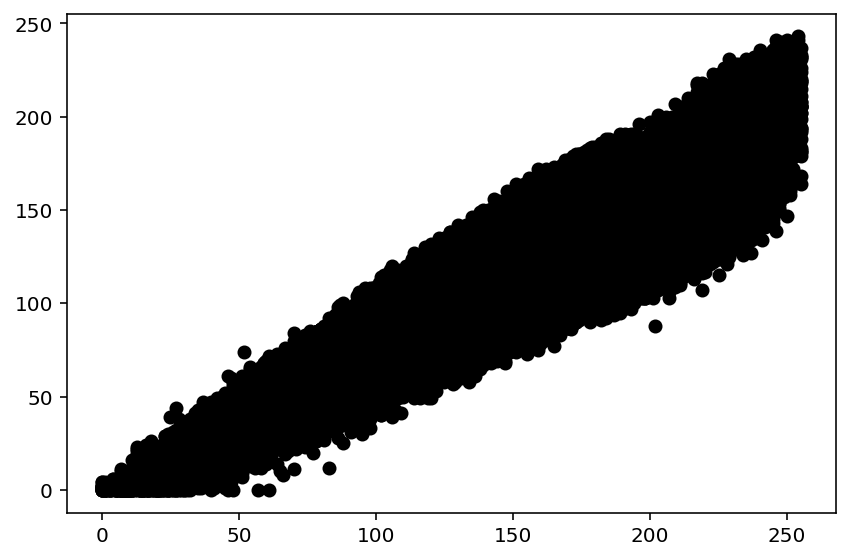

In [203]:
# Model parameters, including the mean
# covariance matrix and the weights for each cluster
init_means = np.array([
    [5, 0],
    [1, 1],
    [0, 5]
])

init_covariances = np.array([
    [[.5, 0.], [0, .5]],
    [[.92, .38], [.38, .91]],
    [[.5, 0.], [0, .5]]
])

init_weights = [1 / 4, 1 / 2, 1 / 4]

# generate data
np.random.seed(4)
X = img_reshapedto2D

plt.plot(X[:, 0], X[:, 1], 'ko')
plt.tight_layout()

In [204]:
class GMM:
    """
    Full covariance Gaussian Mixture Model,
    trained using Expectation Maximization.

    Parameters
    ----------
    n_components : int
        Number of clusters/mixture components in which the data will be
        partitioned into.

    n_iters : int
        Maximum number of iterations to run the algorithm.

    tol : float
        Tolerance. If the log-likelihood between two iterations is smaller than
        the specified tolerance level, the algorithm will stop performing the
        EM optimization.

    seed : int
        Seed / random state used to initialize the parameters.
    """

    def __init__(self, n_components: int, n_iters: int, tol: float, seed: int):
        self.n_components = n_components
        self.n_iters = n_iters
        self.tol = tol
        self.seed = seed

    def fit(self, X):

        # data's dimensionality and responsibility vector
        n_row, n_col = X.shape     
        self.resp = np.zeros((n_row, self.n_components))

        # initialize parameters
        np.random.seed(self.seed)
        chosen = np.random.choice(n_row, self.n_components, replace = False)
        self.means = X[chosen]
        self.weights = np.full(self.n_components, 1 / self.n_components)
        
        # for np.cov, rowvar = False, 
        # indicates that the rows represents obervation
        shape = self.n_components, n_col, n_col
        self.covs = np.full(shape, np.cov(X, rowvar = False))

        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      

        for i in range(self.n_iters):
            print("Iterations: ",i,"\n")
            log_likelihood_new = self._do_estep(X)
            self._do_mstep(X)
            
            print("log_likelihood: ", log_likelihood_new)

            if abs(log_likelihood_new - log_likelihood) <= self.tol:
                self.converged = True
                print("Convergence reached at ",i," Iteration\n")
                break
  
            log_likelihood = log_likelihood_new
            
    
    
            self.log_likelihood_trace.append(log_likelihood)

        return self

    def _do_estep(self, X):
        """
        E-step: compute responsibilities,
        update resp matrix so that resp[j, k] is the responsibility of cluster k for data point j,
        to compute likelihood of seeing data point j given cluster k, use multivariate_normal.pdf
        """
        self._compute_log_likelihood(X)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis = 1)))
        

        # normalize over all possible cluster assignments
        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return log_likelihood

    def _compute_log_likelihood(self, X):
        for k in range(self.n_components):
            prior = self.weights[k]
            likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)            
            self.resp[:, k] = prior * likelihood

        return self

    def _do_mstep(self, X):
        """M-step, update parameters"""

        # total responsibility assigned to each cluster, N^{soft}
        resp_weights = self.resp.sum(axis = 0)
        
        # weights
        self.weights = resp_weights / X.shape[0]

        # means
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        # covariance
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]
            
        return self
    
    def predict(self, X):
        
    
        #Initialize the latent parameters
        shape = X.shape
        #print('Shape of X: ',shape)
        n, m = shape

        likelihood = np.zeros( (n, self.n_components) ) #Initialize likelihood for k clusters as columns and n data points 

        for i in range(self.n_components):
          distribution = multivariate_normal(
              mean=self.means[i], 
              cov=self.covs[i])
          likelihood[:,i] = distribution.pdf(X) #Calculate likelihood for n data points 

        numerator = likelihood * self.weights
        denominator = numerator.sum(axis=1)[:, np.newaxis] #Row wise up Summation for each data points of k cluster
        weights1 = numerator / denominator
        
        return np.argmax(weights1, axis=1)


In [205]:
# use our implementation of the EM algorithm 
# and fit a mixture of Gaussians to the simulated data
gmm = GMM(n_components = 4, n_iters = 50, tol = 1e-4, seed = 4).fit(X)

Iterations:  0 

log_likelihood:  -2168629.2547175153
Iterations:  1 

log_likelihood:  -2045095.9204775083
Iterations:  2 

log_likelihood:  -1978155.1310415096
Iterations:  3 

log_likelihood:  -1963591.9358293663
Iterations:  4 

log_likelihood:  -1959273.396082265
Iterations:  5 

log_likelihood:  -1956415.606255095
Iterations:  6 

log_likelihood:  -1953624.3764765272
Iterations:  7 

log_likelihood:  -1950612.3022293982
Iterations:  8 

log_likelihood:  -1947976.7558429784
Iterations:  9 

log_likelihood:  -1946147.1950365799
Iterations:  10 

log_likelihood:  -1944911.4507610046
Iterations:  11 

log_likelihood:  -1944022.167656113
Iterations:  12 

log_likelihood:  -1943336.1354212551
Iterations:  13 

log_likelihood:  -1942739.7265586206
Iterations:  14 

log_likelihood:  -1942037.817749684
Iterations:  15 

log_likelihood:  -1940954.5190396728
Iterations:  16 

log_likelihood:  -1939898.8018181385
Iterations:  17 

log_likelihood:  -1939229.12033172
Iterations:  18 

log_like

Predicted_classes:  [1 1 1 ... 2 2 2]


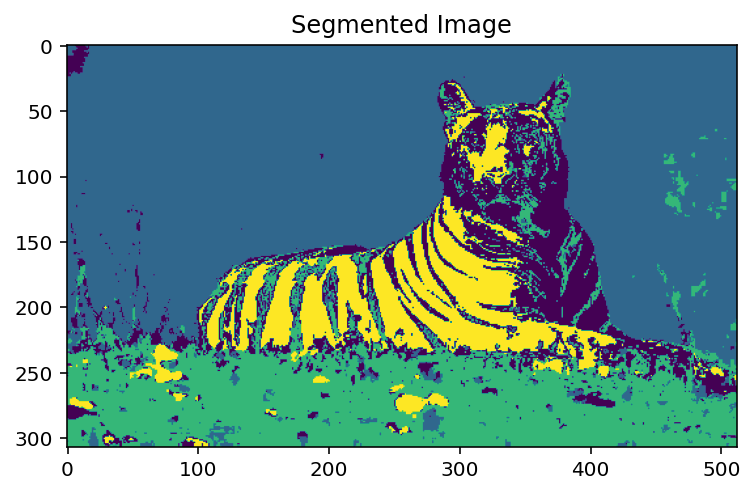

In [211]:
predicted_classes = gmm.predict(X);
print('Predicted_classes: ',predicted_classes)
plt.imshow(predicted_classes.reshape(img.shape[0],img.shape[1]))
plt.title('Segmented Image')
plt.show()

# Accuracy Calculation

In [182]:
def accuracy(inp, targ, axis=-1):
    return (inp == targ).mean()

In [183]:
#classes = np.where(classes==2, 5, classes) #tobe mapped to 2
#classes = np.where(classes==0, 6, classes)
#classes = np.where(classes==1, 7, classes)
#classes = np.where(classes==5, 0, classes) 
#classes = np.where(classes==6, 1, classes) #tobe mapped to 2
#classes = np.where(classes==7, 2, classes)

In [209]:
Percentage = accuracy(original_labels,predicted_classes);
print("Accuracy Percentage: ", Percentage*100,'%')

Accuracy Percentage:  55.76649022801303 %


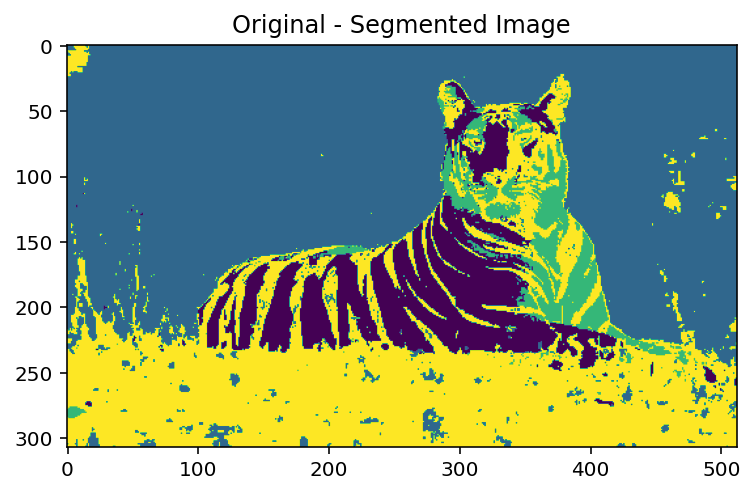

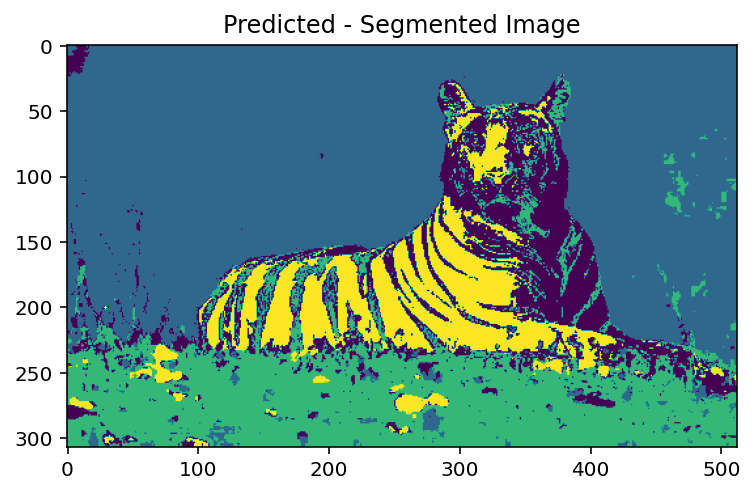

In [210]:
plt.imshow(final_segmented_image)
plt.title('Original - Segmented Image')
plt.show()

plt.imshow(classes.reshape(img.shape[0],img.shape[1]))
plt.title('Predicted - Segmented Image')
plt.show()